### Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

### Set all the Constants

In [2]:
BATCH_SIZE = 16
IMAGE_SIZE = 512
CHANNELS=3
EPOCHS=50

### Import Training data into tensorflow dataset object

In [3]:
Train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Training",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5712 files belonging to 4 classes.


### Import Testing data into tensorflow dataset object

In [4]:
Test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Testing",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1311 files belonging to 4 classes.


### Print the dataset class names

In [5]:
class_names = Train_dataset.class_names
class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

### Visualize some of the images from our dataset

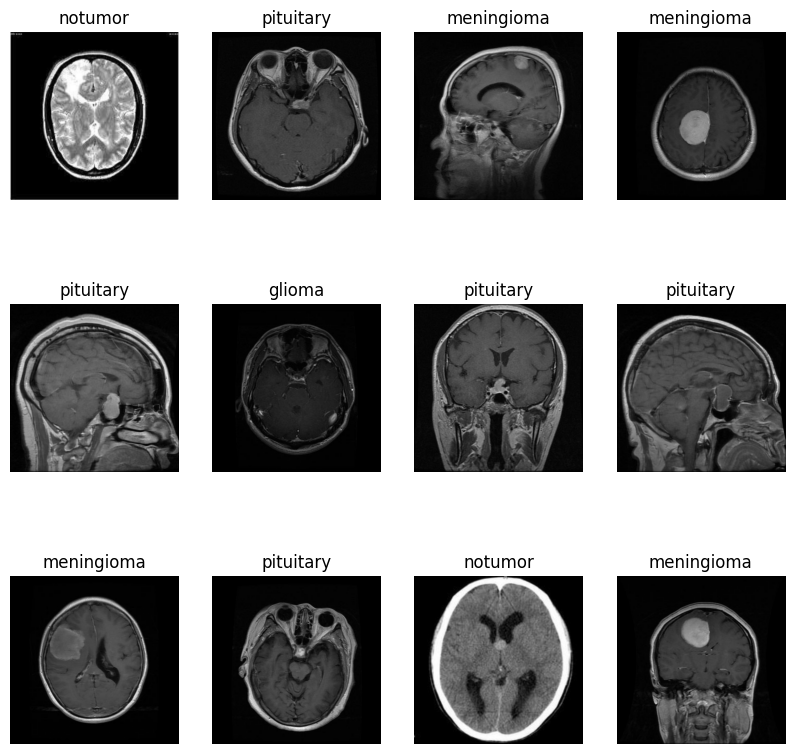

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in Train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Testing Dataset should be bifurcated into 2 subsets, namely:

Validation: Dataset to be tested against while training

Test: Dataset to be tested against after we trained a model

In [7]:
def get_dataset_partitions_tf(ds, val_split=0.5, test_split=0.5, shuffle=True, shuffle_size=10000):
    assert (test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    val_size = int(val_split * ds_size)
    
    val_ds = ds.take(val_size)
    test_ds = ds.skip(val_size)
    
    return  val_ds, test_ds

In [8]:
val_ds, test_ds = get_dataset_partitions_tf(Test_dataset)

In [9]:
len(val_ds)

41

In [10]:
len(test_ds)

41

### Cache, Shuffle, and Prefetch the Dataset

In [11]:
train_ds = Train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization


In [12]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./511),
])

### Data Augmentation

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [14]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


### Model Architecture

In [15]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 512, 512, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 510, 510, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (16, 255, 255, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (16, 253, 253, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (16, 126, 126, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (16, 124, 124, 64)       

### Compiling the Model


In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
357/357 [==============================] - 118s 266ms/step - loss: 0.8586 - accuracy: 0.6626 - val_loss: 0.7767 - val_accuracy: 0.7134
Epoch 2/50
357/357 [==============================] - 88s 246ms/step - loss: 0.5910 - accuracy: 0.7740 - val_loss: 0.5997 - val_accuracy: 0.7744
Epoch 3/50
357/357 [==============================] - 87s 243ms/step - loss: 0.4774 - accuracy: 0.8125 - val_loss: 0.5539 - val_accuracy: 0.7912
Epoch 4/50
357/357 [==============================] - 87s 244ms/step - loss: 0.4017 - accuracy: 0.8505 - val_loss: 0.4342 - val_accuracy: 0.8491
Epoch 5/50
357/357 [==============================] - 89s 248ms/step - loss: 0.3293 - accuracy: 0.8766 - val_loss: 0.4656 - val_accuracy: 0.8140
Epoch 6/50
357/357 [==============================] - 88s 246ms/step - loss: 0.2981 - accuracy: 0.8897 - val_loss: 0.3752 - val_accuracy: 0.8598
Epoch 7/50
357/357 [==============================] - 86s 241ms/step - loss: 0.2540 - accuracy: 0.9070 - val_loss: 0.3279 - val_a

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [20]:
import numpy as np

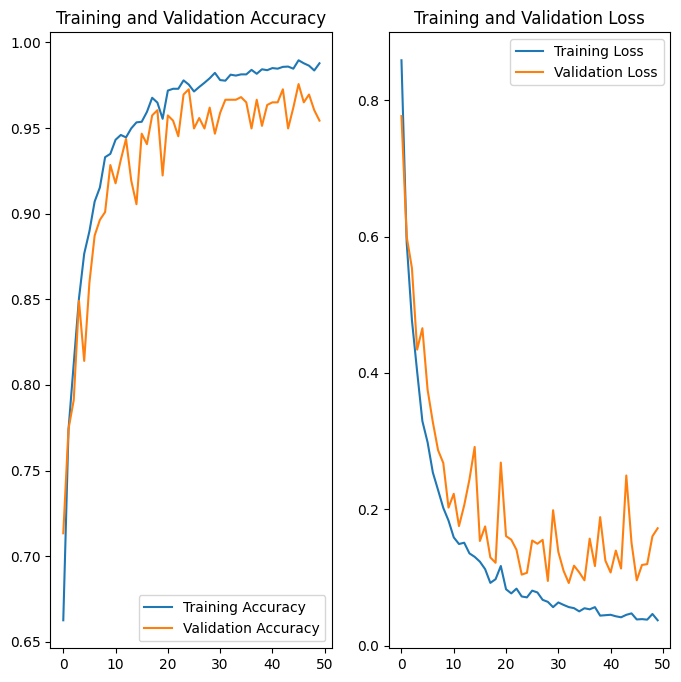

In [21]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Write a function for inference

In [22]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 23ms/step


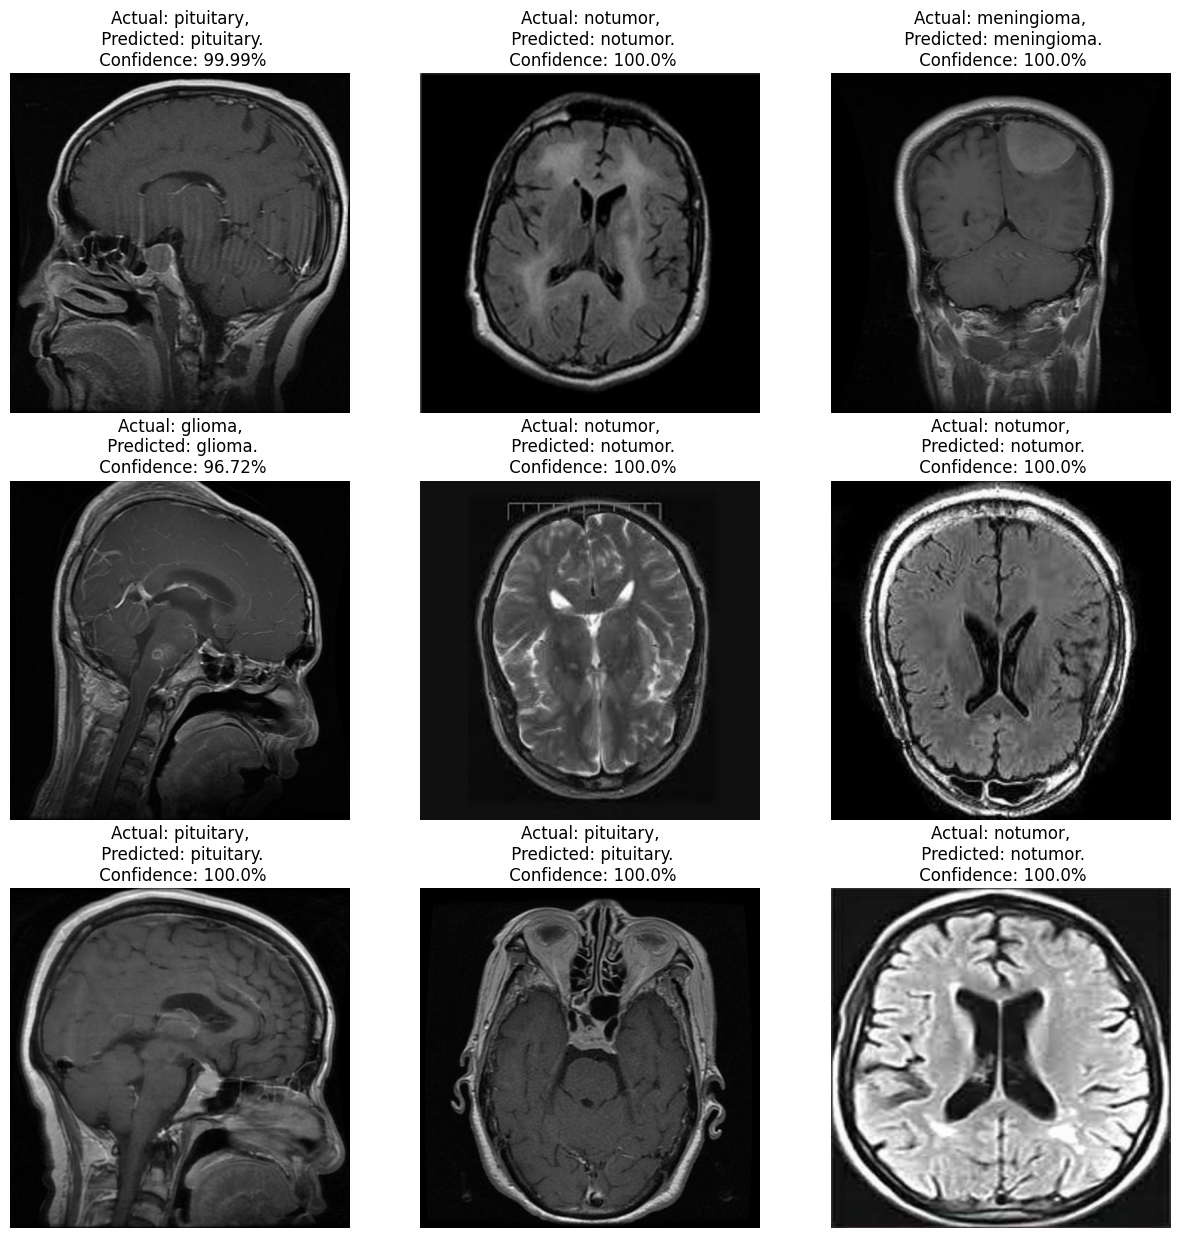

In [27]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model


In [28]:
model.save("/api/saved_models/tumor.h5")